In [2]:
from pathlib import Path

import torch

from dynamic_fusion.network_trainer.configuration import TrainerConfiguration
from dynamic_fusion.network_trainer.network_loader import NetworkLoader

In [11]:
cuda_timers = {}
timers = {}
import numpy as np
import atexit

class CudaTimer:
    def __init__(self, timer_name=''):
        self.timer_name = timer_name
        if self.timer_name not in cuda_timers:
            cuda_timers[self.timer_name] = []

        self.start = torch.cuda.Event(enable_timing=True)
        self.end = torch.cuda.Event(enable_timing=True)

    def __enter__(self):
        self.start.record()
        return self

    def __exit__(self, *args):
        self.end.record()
        torch.cuda.synchronize()
        cuda_timers[self.timer_name].append(self.start.elapsed_time(self.end))

def print_timing_info(n: int):
    print('== Timing statistics ==')
    for timer_name, timing_values in [*cuda_timers.items(), *timers.items()]:
        timing_value = np.mean(np.array(timing_values) / n)
        if timing_value < 1000.0:
            print('{}: {:.2f} ms'.format(timer_name, timing_value))
        else:
            print('{}: {:.2f} s'.format(timer_name, timing_value / 1000.0))

atexit.register(print_timing_info)

<function __main__.print_timing_info(n: int)>

In [12]:
checkpoints = [Path("../runs/RESULTS/STANDARD")]
checkpoint_dir = checkpoints[0]

config_path = checkpoint_dir / "config.json"
with config_path.open("r", encoding="utf8") as f:
    json_config = f.read()
# Parse the JSON string back into a Configuration instance
config = TrainerConfiguration.parse_raw(json_config)

# config.network_loader.decoding_checkpoint_path = checkpoint_dir / "latest_checkpoint.pt"
config.network_loader.encoding_checkpoint_path = checkpoint_dir / "latest_checkpoint.pt"


config.network_loader.decoding.hidden_size = 64
config.network_loader.decoding.hidden_layers = 3

encoder, decoder = NetworkLoader(config.network_loader, config.shared).run()


In [29]:
cuda_timers = {}
SHAPE = (1280, 720)
device = torch.device("cuda")
encoder = encoder.to(device)
decoder = decoder.to(device)

with torch.no_grad():
    tensor = torch.rand(1, 8, *SHAPE).to(device)
    cs = torch.rand(*SHAPE, 144*3 + 3).to(device)
    encoder.reset_states()
    encoder(tensor)

    N = 1
    with CudaTimer("Ours_ENC"):
        for i in range(N):
            encoder(tensor)
  

    with CudaTimer("Ours_Dec"):
        for i in range(N):
            decoder(cs)


print_timing_info(N)


== Timing statistics ==
Ours_ENC: 102.43 ms
Ours_Dec: 41.44 ms


In [98]:
fire = 2
e2vid = 7.3
enc = 3.7
dec = 1.1

upsampling = np.linspace(1, 50, 100)
encoder_runs_per_second = 20
runs_per_second = upsampling * encoder_runs_per_second
time_per_run = 1 / runs_per_second

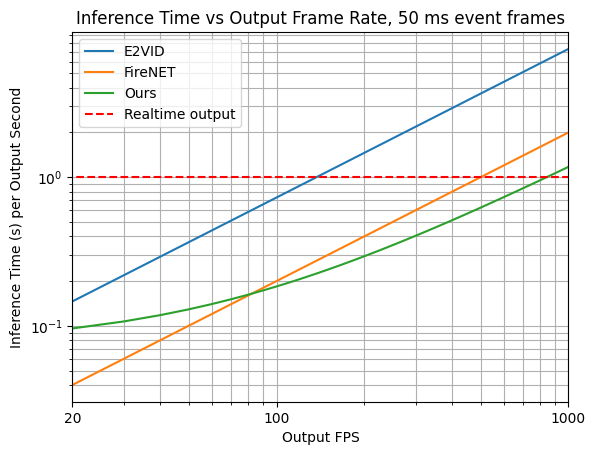

: 

In [130]:
from matplotlib import pyplot as plt
import matplotlib
plt.plot(runs_per_second, (e2vid*runs_per_second) / 1000, label="E2VID")
plt.plot(runs_per_second, fire*runs_per_second / 1000, label="FireNET")
plt.plot(runs_per_second, (enc*encoder_runs_per_second + dec*runs_per_second) / 1000, label="Ours")

# plt.plot(runs_per_second, time_per_run, '--', label = 'Realtime')
plt.hlines(1, 0, runs_per_second[-1], 'red', '--', label='Realtime output')

plt.xlabel('Output FPS')

plt.gca().set_yscale('log')
plt.gca().set_xscale('log')
plt.gca().set_xticks([20, 100, 1000])
plt.gca().get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

# plt.ylim([0, 1500])
plt.xlim([20,1000])

plt.ylabel('Inference Time (s) per Output Second')
plt.title("Inference Time vs Output Frame Rate, 50 ms event frames")
plt.legend()
plt.grid(which='both')
plt.savefig('results/real-time.png')